In [1]:
# !pip install ipython-autotime 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from gensim.models import Word2Vec, KeyedVectors
from email.parser import Parser
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from tqdm.notebook import tqdm

from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from statistics import mean
%load_ext autotime

time: 0 ns (started: 2021-06-11 16:35:01 +03:00)


## Preprocessing

In [2]:
# ham_src=r'C:\Users\kypro\Downloads\Thesis\Enron Dataset\enron1\enron1\ham'
# spam_src=r'C:\Users\kypro\Downloads\Thesis\Enron Dataset\enron1\enron1\spam'
ham_src=r'C:\Users\kypro\Downloads\Thesis\Enron Dataset\enron2\ham'
spam_src=r'C:\Users\kypro\Downloads\Thesis\Enron Dataset\enron2\spam'

time: 0 ns (started: 2021-06-11 16:35:01 +03:00)


In [3]:
#Load every ham email on ham list
def data_preprocessing(src):
    clean_list=[]
    directory=src
    for filename in os.listdir(directory):
        try:
             with open(os.path.join(directory, filename), "r") as f:
                data = f.read()
                email = Parser().parsestr(data)
                data_p=email.get_payload()
                temp_list=data_p.split('subject')
                for x in range(len(temp_list)):
                    email = Parser().parsestr(temp_list[x])
                    clean_list.append(email.get_payload())
        except:
            print("PROBLEM",filename)
            continue
    return clean_list

time: 0 ns (started: 2021-06-11 16:35:01 +03:00)


# Here we load the data and remove some elements

In [4]:
ham_list=data_preprocessing(ham_src)
spam_list=data_preprocessing(spam_src)

time: 7.23 s (started: 2021-06-11 16:35:01 +03:00)


In [5]:
#assign the class 
df_ham = pd.DataFrame({"Mails":ham_list})
df_ham['Class']=0
df_spam = pd.DataFrame({"Mails":spam_list})
df_spam['Class']=1

time: 0 ns (started: 2021-06-11 16:35:08 +03:00)


In [6]:
#Drop nan values and duplicates 
df_ham=df_ham.dropna()
df_spam=df_spam.dropna()
df_ham=df_ham.drop_duplicates()
df_spam=df_spam.drop_duplicates()

time: 47 ms (started: 2021-06-11 16:35:08 +03:00)


In [7]:
#Combine datasets
data_set=pd.concat([df_ham, df_spam], ignore_index=True)

time: 0 ns (started: 2021-06-11 16:35:08 +03:00)


In [ ]:
# data_set = data_set.sample(frac=1).reset_index(drop=True)

In [ ]:
# dataset, test, dataset_labels, test_labels = train_test_split(data_set, data_set['Class'], test_size=0.1, random_state=42)

In [8]:
# df = pd.DataFrame(data=dataset_labels, columns=list('a'))
train_texts = list(data_set["Mails"].values)
train_labels=data_set['Class'].values

time: 0 ns (started: 2021-06-11 16:35:08 +03:00)


In [ ]:
# train_data=np.array(train_data)
# val_data=np.array(val_data)

# Continue Normal Preprocessing

In [ ]:
# train_labels = data_set.to_numpy()
# test_texts = list(test["Mails"].values)
# print("Example Training Text:\n\n",train_texts[0])

In [9]:
def preprocess_corpus(texts):
    #importing stop words like in, the, of so that these can be removed from texts
    #as these words dont help in determining the classes(Whether a sentence is toxic or not)
    mystopwords = set(stopwords.words("english"))
    def remove_stops_digits(tokens):
        #Nested function that lowercases, removes stopwords and digits from a list of tokens
        return [token.lower() for token in tokens if token not in mystopwords and not token.isdigit()
               and token not in punctuation]
    #This return statement below uses the above function and tokenizes output further. 
    return [remove_stops_digits(word_tokenize(text)) for text in tqdm(texts)]

#Preprocess both for training and test data
train_texts_processed = preprocess_corpus(train_texts)
# test_texts_processed = preprocess_corpus(test_texts)
print("Example Training Prepocessed Text\n\n", train_texts_processed[0])


Example Training Prepocessed Text

 ['thank']
time: 12.8 s (started: 2021-06-11 16:35:09 +03:00)


In [ ]:
# type(train_texts_processed)
# str_list = filter(lambda item: item, train_texts_processed)
# train_texts_processed=list(str_list)
# train_texts_processed=list(str_list)

In [10]:
from gensim.models import KeyedVectors
w2v_google_news = KeyedVectors.load_word2vec_format(r'C:\Users\kypro\Downloads\Thesis\TestinHFO\Hope_1\GoogleNews-vectors-negative300.bin', binary=True)
print(len(w2v_google_news.vocab))

3000000
time: 28.3 s (started: 2021-06-11 16:35:22 +03:00)


In [11]:
#Function that takes in the input text dataset in form of list of lists where each sentence is a list of words all the sentences are 
#inside a list
def embedding_feats(list_of_lists, DIMENSION, w2v_model):
    zeros_vector = np.zeros(DIMENSION)
    feats = []
    missing = set()
    missing_sentences = set()
    #Traverse over each sentence
    for tokens in tqdm(list_of_lists):
        # Initially assign zeroes as the embedding vector for the sentence
        feat_for_this = zeros_vector
        #Count the number of words in the embedding for this sentence
        count_for_this = 0
        #Traverse over each word of a sentence
        for token in tokens:
            #Check if the word is in the embedding vector
            if token in w2v_model:
                #Add the vector of the word to vector for the sentence
                feat_for_this += w2v_model[token]
                count_for_this +=1
            #Else assign the missing word to missing set just to have a look at it
            else:
                missing.add(token)
        #If no words are found in the embedding for the sentence
        if count_for_this == 0:
            #Assign all zeroes vector for that sentence
            feats.append(feat_for_this)
            #Assign the missing sentence to missing_sentences just to have a look at it
            missing_sentences.add(' '.join(tokens))
        #Else take average of the values of the embedding for each word to get the embedding of the sentence
        else:
            feats.append(feat_for_this/count_for_this)
    return feats, missing, missing_sentences

time: 0 ns (started: 2021-06-11 16:35:50 +03:00)


In [12]:
#Embeddings for the train dataset
train_vectors, missing, missing_sentences = embedding_feats(train_texts_processed, 300, w2v_google_news)
train_data, val_data, train_cats, val_cats = train_test_split(train_vectors, train_labels)


time: 2.64 s (started: 2021-06-11 16:35:50 +03:00)


# Apply the same reshaping as HFO

In [32]:
train_data=np.array(train_data)
val_data=np.array(val_data)

time: 16 ms (started: 2021-06-11 17:08:57 +03:00)


In [33]:
images = train_data.reshape(train_data.shape[0], -1)
val_data = val_data.reshape(val_data.shape[0], -1)

time: 0 ns (started: 2021-06-11 17:08:58 +03:00)


In [34]:
# train Data
_IMAGE_HEIGHT, _IMAGE_WIDTH, _IMAGE_CHANNELS = 50,50,1
zero_to_append = np.zeros((images.shape[0],_IMAGE_CHANNELS*_IMAGE_HEIGHT*_IMAGE_WIDTH-np.prod(images.shape[1:])))
images = np.append(images, zero_to_append, axis=1)

#Val Data

_IMAGE_HEIGHT, _IMAGE_WIDTH, _IMAGE_CHANNELS = 50,50,1
zero_to_append = np.zeros((val_data.shape[0],_IMAGE_CHANNELS*_IMAGE_HEIGHT*_IMAGE_WIDTH-np.prod(val_data.shape[1:])))
val_data = np.append(val_data, zero_to_append, axis=1)

time: 141 ms (started: 2021-06-11 17:08:58 +03:00)


In [35]:
_IMAGE_HEIGHT, _IMAGE_WIDTH, _IMAGE_CHANNELS = 50,50,1
images_shape = [images.shape[0], _IMAGE_CHANNELS, _IMAGE_HEIGHT, _IMAGE_WIDTH]
# images normalization and zero centering
images = images.reshape(images_shape[0], -1)
images = images/255.0
mean_tr = images.mean(axis=0) 
images = images - mean_tr
images = images.reshape(images_shape)
# Tensorflow accepts data shape: B x H x W x C
images = np.transpose(images, (0, 2, 3, 1))

#Val Data
_IMAGE_HEIGHT, _IMAGE_WIDTH, _IMAGE_CHANNELS = 50,50,1
images_shape = [val_data.shape[0], _IMAGE_CHANNELS, _IMAGE_HEIGHT, _IMAGE_WIDTH]
# images normalization and zero centering
val_data = val_data.reshape(images_shape[0], -1)
val_data = val_data/255.0
mean_tr = val_data.mean(axis=0) 
val_data = val_data - mean_tr
val_data = val_data.reshape(images_shape)
# Tensorflow accepts data shape: B x H x W x C
val_data = np.transpose(val_data, (0, 2, 3, 1))

time: 156 ms (started: 2021-06-11 17:08:59 +03:00)


In [36]:
#TRAIN LABELS
train_cats=list(map(lambda el:[el], train_cats))
train_cats=np.array(train_cats)
train_cats = train_cats.reshape(-1)
#VAL LABELS
val_cats=list(map(lambda el:[el], val_cats))
val_cats=np.array(val_cats)
val_cats = val_cats.reshape(-1)

time: 0 ns (started: 2021-06-11 17:09:01 +03:00)


In [37]:
#TRAIN DATA
label_enum, labels = np.unique(train_cats, return_inverse=True)
num_cls = train_cats.max()+1

forward_map = dict(zip(label_enum, np.arange(2)))
train_cats = np.expand_dims(train_cats, axis=1)
train_cats = np.apply_along_axis(lambda x:forward_map[x[0]], axis=1, arr=train_cats)

#convert groundtruth to one-hot encoding

# train_cats = np.eye(2)[train_cats]
# train_cats = train_cats.astype('float32')


#VAL DATA

label_enum, labels = np.unique(val_cats, return_inverse=True)
num_cls = val_cats.max()+1

forward_map = dict(zip(label_enum, np.arange(2)))
val_cats = np.expand_dims(val_cats, axis=1)
val_cats = np.apply_along_axis(lambda x:forward_map[x[0]], axis=1, arr=val_cats)

# convert groundtruth to one-hot encoding

# val_cats = np.eye(2)[val_cats]
# val_cats = val_cats.astype('float32')     

time: 31 ms (started: 2021-06-11 17:09:02 +03:00)


In [38]:
# Importing libraries
import tensorflow as tf
import keras
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.optimizers import Adam
from keras.optimizers import SGD

time: 47 ms (started: 2021-06-11 17:09:03 +03:00)


In [ ]:
# cnn_model = Sequential([
#     Conv2D(filters=32,kernel_size=3,activation='relu',input_shape = [50,50,1]),
#     MaxPooling2D(pool_size=2) ,# down sampling the output instead of 28*28 it is 14*14
#     Dropout(0.2),
#     Flatten(), # flatten out the layers
#     Dense(2,activation = 'softmax')
    
# ])

In [39]:

cnn_model = Sequential([
    keras.layers.Conv2D(32, [5, 5], padding='same', activation=tf.nn.relu, input_shape=[50,50,1]),
    keras.layers.MaxPool2D([2, 2], strides=2),
    keras.layers.Conv2D(64, [3, 3], padding='same', activation=tf.nn.relu),
    keras.layers.MaxPool2D([2, 2], strides=2),
    keras.layers.Conv2D(64, [3, 3], padding='same', activation=tf.nn.relu),
    keras.layers.MaxPool2D([2, 2], strides=2),
    keras.layers.Flatten(),
    keras.layers.Dense(2,activation='softmax')])

time: 63 ms (started: 2021-06-11 17:09:06 +03:00)


In [40]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 50, 50, 32)        832       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)             

# SGD

In [41]:
cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer=SGD(lr=0.001),metrics =['accuracy'])

time: 47 ms (started: 2021-06-11 17:09:09 +03:00)


In [42]:
history = cnn_model.fit(
    images,
    train_cats,
    batch_size=128,
    epochs=75,
    verbose=1,
    validation_data=(val_data,val_cats),
)

Train on 6597 samples, validate on 2199 samples
Epoch 1/75
6597/6597 [==============================] - ETA: 0s - loss: 0.6276 - acc: 0.8186WARNING:tensorflow:From C:\Users\kypro\anaconda3\envs\anti_ph\lib\site-packages\tensorflow\python\keras\engine\training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
6597/6597 [==============================] - 10s 1ms/sample - loss: 0.6276 - acc: 0.8186 - val_loss: 0.5895 - val_acc: 0.7908
Epoch 2/75
6597/6597 [==============================] - 10s 1ms/sample - loss: 0.5447 - acc: 0.8205 - val_loss: 0.5368 - val_acc: 0.8131
Epoch 3/75
6597/6597 [==============================] - 11s 2ms/sample - loss: 0.4992 - acc: 0.8214 - val_loss: 0.5052 - val_acc: 0.7963
Epoch 4/75
6597/6597 [==============================] - 12s 2ms/sample - loss: 0.4728 - a

Epoch 57/75
6597/6597 [==============================] - 10s 2ms/sample - loss: 0.4046 - acc: 0.8484 - val_loss: 0.4265 - val_acc: 0.8276
Epoch 58/75
6597/6597 [==============================] - 12s 2ms/sample - loss: 0.4039 - acc: 0.8492 - val_loss: 0.4262 - val_acc: 0.8258
Epoch 59/75
6597/6597 [==============================] - 11s 2ms/sample - loss: 0.4033 - acc: 0.8486 - val_loss: 0.4256 - val_acc: 0.8258
Epoch 60/75
6597/6597 [==============================] - 10s 2ms/sample - loss: 0.4027 - acc: 0.8484 - val_loss: 0.4248 - val_acc: 0.8267
Epoch 61/75
6597/6597 [==============================] - 10s 1ms/sample - loss: 0.4021 - acc: 0.8490 - val_loss: 0.4245 - val_acc: 0.8258
Epoch 62/75
6597/6597 [==============================] - 10s 2ms/sample - loss: 0.4016 - acc: 0.8486 - val_loss: 0.4235 - val_acc: 0.8290
Epoch 63/75
6597/6597 [==============================] - 10s 1ms/sample - loss: 0.4010 - acc: 0.8493 - val_loss: 0.4229 - val_acc: 0.8295
Epoch 64/75
6597/6597 [===========

## Prediction and Confusion Matrix

In [43]:
train_predict = cnn_model.predict_classes(images)
# train_cats

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
time: 3.02 s (started: 2021-06-11 17:22:04 +03:00)


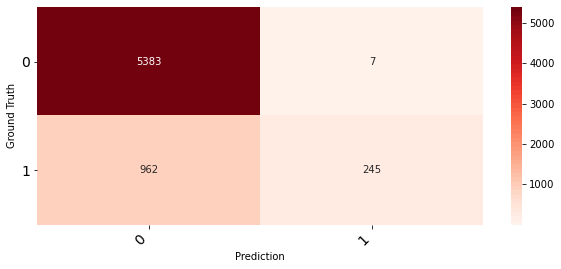

time: 328 ms (started: 2021-06-11 17:22:07 +03:00)


In [44]:

fig = plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(train_cats, train_predict)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

In [45]:
valid_predict = cnn_model.predict_classes(val_data)
# val_cats

time: 1 s (started: 2021-06-11 17:22:07 +03:00)


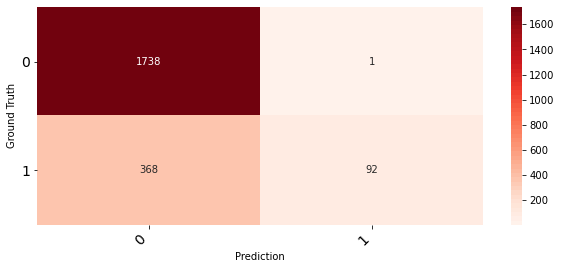

time: 219 ms (started: 2021-06-11 17:22:08 +03:00)


In [46]:
fig = plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(val_cats, valid_predict)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

SGD Enron 1
loss: 0.4674 - acc: 0.7845 - val_loss: 0.4694 - val_acc: 0.7959
SGD Enron 2

# Adam

In [ ]:
cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001),metrics =['accuracy'])

In [ ]:
history = cnn_model.fit(
    images,
    train_cats,
    batch_size=128,
    epochs=75,
    verbose=1,
    validation_data=(val_data,val_cats),
)

loss: 0.0521 - acc: 0.9885 - val_loss: 0.1585 - val_acc: 0.9125

# HFO

In [13]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import math
import pdb
from tensorflow.python.client import device_lib
import numpy as np
import tensorflow.compat.v1.keras as keras

Instructions for updating:
non-resource variables are not supported in the long term
time: 3.11 s (started: 2021-06-11 16:35:53 +03:00)


In [14]:
def CNN_4layers(input_shape, output_shape):
	layers = [
		keras.layers.Conv2D(32, [5, 5], padding='same', activation=tf.nn.relu, input_shape=input_shape),
		keras.layers.MaxPool2D([2, 2], strides=2),
		keras.layers.Conv2D(64, [3, 3], padding='same', activation=tf.nn.relu),
		keras.layers.MaxPool2D([2, 2], strides=2),
		keras.layers.Conv2D(64, [3, 3], padding='same', activation=tf.nn.relu),
		keras.layers.MaxPool2D([2, 2], strides=2),
		keras.layers.Flatten(),
		keras.layers.Dense(output_shape),
	]
	return keras.models.Sequential(layers)

def CNN_7layers(input_shape, output_shape):
	layers = [
		keras.layers.Conv2D(32, [5, 5], padding='same', activation=tf.nn.relu, input_shape=input_shape),
		keras.layers.Conv2D(32, [3, 3], padding='same', activation=tf.nn.relu),
		keras.layers.MaxPool2D([2, 2], strides=2),
		keras.layers.Conv2D(64, [3, 3], padding='same', activation=tf.nn.relu),
		keras.layers.Conv2D(64, [3, 3], padding='same', activation=tf.nn.relu),
		keras.layers.MaxPool2D([2, 2], strides=2),
		keras.layers.Conv2D(64, [3, 3], padding='same', activation=tf.nn.relu),
		keras.layers.Conv2D(128, [3, 3], padding='same', activation=tf.nn.relu),
		keras.layers.MaxPool2D([2, 2], strides=2),
		keras.layers.Flatten(),
		keras.layers.Dense(output_shape),
	]
	return keras.models.Sequential(layers)

def CNN_model(net, input_shape, output_shape):
	return globals()[net](input_shape, output_shape)

def CNN(net, num_cls, dim):
	_NUM_CLASSES = num_cls
	_IMAGE_HEIGHT, _IMAGE_WIDTH, _IMAGE_CHANNELS = dim

	with tf.name_scope('main_params'):
		x = tf.placeholder(tf.float32, shape=[None, _IMAGE_HEIGHT, _IMAGE_WIDTH, _IMAGE_CHANNELS], name='input_of_net')
		y = tf.placeholder(tf.float32, shape=[None, _NUM_CLASSES], name='labels')

	outputs = CNN_model(net, dim, num_cls)(x)
	outputs = tf.identity(outputs, name='output_of_net')

	return (x, y, outputs)

time: 0 ns (started: 2021-06-11 16:35:56 +03:00)


In [15]:
import pdb
import time
import os
import math
def Rop(f, weights, v):
	"""Implementation of R operator
	Args:
		f: any function of weights
		weights: list of tensors.
		v: vector for right multiplication
	Returns:
		Jv: Jaccobian vector product, length same as
			the number of output of f
	"""
	if type(f) == list:
		u = [tf.zeros_like(ff) for ff in f]
	else:
		u = tf.zeros_like(f)  # dummy variable
	g = tf.gradients(ys=f, xs=weights, grad_ys=u)
	return tf.gradients(ys=g, xs=u, grad_ys=v)

def Gauss_Newton_vec(outputs, loss, weights, v):
	"""Implements Gauss-Newton vector product.
	Args:
		loss: Loss function.
		outputs: outputs of the last layer (pre-softmax).
		weights: Weights, list of tensors.
		v: vector to be multiplied with Gauss Newton matrix
	Returns:
		J'BJv: Guass-Newton vector product.
	"""
	# Validate the input
	if type(weights) == list:
		if len(v) != len(weights):
			raise ValueError("weights and v must have the same length.")

	grads_outputs = tf.gradients(ys=loss, xs=outputs)
	BJv = Rop(grads_outputs, weights, v)
	JBJv = tf.gradients(ys=outputs, xs=weights, grad_ys=BJv)
	return JBJv
	

class newton_cg(object):
	def __init__(self, config, sess, outputs, loss):
		"""
		initialize operations and vairables that will be used in newton
		args:
			sess: tensorflow session
			outputs: output of the neural network (pre-softmax layer)
			loss: function to calculate loss
		"""
		super(newton_cg, self).__init__()
		self.sess = sess
		self.config = config
		self.outputs = outputs
		self.loss = loss
		self.param = tf.compat.v1.trainable_variables()

		self.CGiter = 0
		FLOAT = tf.float32
		model_weight = self.vectorize(self.param)
		
		# initial variable used in CG
		zeros = tf.zeros(model_weight.get_shape(), dtype=FLOAT)
		self.r = tf.Variable(zeros, dtype=FLOAT, trainable=False)
		self.v = tf.Variable(zeros, dtype=FLOAT, trainable=False)
		self.s = tf.Variable(zeros, dtype=FLOAT, trainable=False)
		self.g = tf.Variable(zeros, dtype=FLOAT, trainable=False)
		# initial Gv, f for method minibatch
		self.Gv = tf.Variable(zeros, dtype=FLOAT, trainable=False)
		self.f = tf.Variable(0., dtype=FLOAT, trainable=False)

		# rTr, cgtol and beta to be used in CG
		self.rTr = tf.Variable(0., dtype=FLOAT, trainable=False)
		self.cgtol = tf.Variable(0., dtype=FLOAT, trainable=False)
		self.beta = tf.Variable(0., dtype=FLOAT, trainable=False)

		# placeholder alpha, old_alpha and lambda
		self.alpha = tf.compat.v1.placeholder(FLOAT, shape=[])
		self.old_alpha = tf.compat.v1.placeholder(FLOAT, shape=[])
		self._lambda = tf.compat.v1.placeholder(FLOAT, shape=[])

		self.num_grad_segment = math.ceil(self.config.num_data/self.config.bsize)
		self.num_Gv_segment = math.ceil(self.config.GNsize/self.config.bsize)

		cal_loss, cal_lossgrad, cal_lossGv, \
		add_reg_avg_loss, add_reg_avg_grad, add_reg_avg_Gv, \
		zero_loss, zero_grad, zero_Gv = self._ops_in_minibatch()

		# initial operations that will be used in minibatch and newton
		self.cal_loss = cal_loss
		self.cal_lossgrad = cal_lossgrad
		self.cal_lossGv = cal_lossGv
		self.add_reg_avg_loss = add_reg_avg_loss
		self.add_reg_avg_grad = add_reg_avg_grad
		self.add_reg_avg_Gv = add_reg_avg_Gv
		self.zero_loss = zero_loss
		self.zero_grad = zero_grad
		self.zero_Gv = zero_Gv

		self.CG, self.update_v = self._CG()
		self.init_cg_vars = self._init_cg_vars()
		self.update_gs = tf.tensordot(self.s, self.g, axes=1)
		self.update_sGs = 0.5*tf.tensordot(self.s, -self.g-self.r-self._lambda*self.s, axes=1)
		self.update_model = self._update_model()
		self.gnorm = self.calc_norm(self.g)


	def vectorize(self, tensors):
		if isinstance(tensors, list) or isinstance(tensors, tuple):
			vector = [tf.reshape(tensor, [-1]) for tensor in tensors]
			return tf.concat(vector, 0) 
		else:
			return tensors 
	
	def inverse_vectorize(self, vector, param):
		if isinstance(vector, list):
			return vector
		else:
			tensors = []
			offset = 0
			num_total_param = np.sum([np.prod(p.shape.as_list()) for p in param])
			for p in param:
				numel = np.prod(p.shape.as_list())
				tensors.append(tf.reshape(vector[offset: offset+numel], p.shape))
				offset += numel

			assert offset == num_total_param
			return tensors

	def calc_norm(self, v):
		# default: frobenius norm
		if isinstance(v, list):
			norm = 0.
			for p in v:
				norm = norm + tf.norm(tensor=p)**2
			return norm**0.5
		else:
			return tf.norm(tensor=v)

	def _ops_in_minibatch(self):
		"""
		Define operations that will be used in method minibatch
		Vectorization is already a deep copy operation.
		Before using newton method, loss needs to be summed over training samples
		to make results consistent.
		"""

		def cal_loss():
			return tf.compat.v1.assign(self.f, self.f + self.loss)

		def cal_lossgrad():
			update_f = tf.compat.v1.assign(self.f, self.f + self.loss)

			grad = tf.gradients(ys=self.loss, xs=self.param)
			grad = self.vectorize(grad)
			update_grad = tf.compat.v1.assign(self.g, self.g + grad)

			return tf.group(*[update_f, update_grad])

		def cal_lossGv():
			v = self.inverse_vectorize(self.v, self.param)
			Gv = Gauss_Newton_vec(self.outputs, self.loss, self.param, v)
			Gv = self.vectorize(Gv)
			return tf.compat.v1.assign(self.Gv, self.Gv + Gv) 

		# add regularization term to loss, gradient and Gv and further average over batches 
		def add_reg_avg_loss():
			model_weight = self.vectorize(self.param)
			reg = (self.calc_norm(model_weight))**2
			reg = 1.0/(2*self.config.C) * reg
			return tf.compat.v1.assign(self.f, reg + self.f/self.config.num_data)

		def add_reg_avg_lossgrad():
			model_weight = self.vectorize(self.param)
			reg_grad = model_weight/self.config.C
			return tf.compat.v1.assign(self.g, reg_grad + self.g/self.config.num_data)

		def add_reg_avg_lossGv():
			return tf.compat.v1.assign(self.Gv, (self._lambda + 1/self.config.C)*self.v
			 + self.Gv/self.config.GNsize) 

		# zero out loss, grad and Gv 
		def zero_loss():
			return tf.compat.v1.assign(self.f, tf.zeros_like(self.f))
		def zero_grad():
			return tf.compat.v1.assign(self.g, tf.zeros_like(self.g))
		def zero_Gv():
			return tf.compat.v1.assign(self.Gv, tf.zeros_like(self.Gv))

		return (cal_loss(), cal_lossgrad(), cal_lossGv(),
				add_reg_avg_loss(), add_reg_avg_lossgrad(), add_reg_avg_lossGv(),
				zero_loss(), zero_grad(), zero_Gv())

	def minibatch(self, data_batch, place_holder_x, place_holder_y, mode):
		"""
		A function to evaluate either function value, global gradient or sub-sampled Gv
		"""
		if mode not in ('funonly', 'fungrad', 'Gv'):
			raise ValueError('Unknown mode other than funonly & fungrad & Gv!')

		inputs, labels = data_batch
		num_data = labels.shape[0]
		num_segment = math.ceil(num_data/self.config.bsize)
		x, y = place_holder_x, place_holder_y

		# before estimation starts, need to zero out f, grad and Gv according to the mode

		if mode == 'funonly':
			assert num_data == self.config.num_data
			assert num_segment == self.num_grad_segment
			self.sess.run(self.zero_loss)
		elif mode == 'fungrad':
			assert num_data == self.config.num_data
			assert num_segment == self.num_grad_segment
			self.sess.run([self.zero_loss, self.zero_grad])
		else:
			assert num_data == self.config.GNsize
			assert num_segment == self.num_Gv_segment
			self.sess.run(self.zero_Gv)

		for i in range(num_segment):
			
			load_time = time.time()
			idx = np.arange(i * self.config.bsize, min((i+1) * self.config.bsize, num_data))
			batch_input = inputs[idx]
            
			batch_labels = labels[idx]
         
			batch_input = np.ascontiguousarray(batch_input)
			batch_labels = np.ascontiguousarray(batch_labels)
			self.config.elapsed_time += time.time() - load_time

			if mode == 'funonly':

				self.sess.run(self.cal_loss, feed_dict={
							x: batch_input, 
							y: batch_labels,})

			elif mode == 'fungrad':
				
				self.sess.run(self.cal_lossgrad, feed_dict={
							x: batch_input, 
							y: batch_labels,})
				
			else:
				
				self.sess.run(self.cal_lossGv, feed_dict={
							x: batch_input, 
							y: batch_labels})

		# average over batches
		if mode == 'funonly':
			self.sess.run(self.add_reg_avg_loss)
		elif mode == 'fungrad':
			self.sess.run([self.add_reg_avg_loss, self.add_reg_avg_grad])
		else:
			self.sess.run(self.add_reg_avg_Gv, 
				feed_dict={self._lambda: self.config._lambda})


	def _update_model(self):
		update_model_ops = []
		x = self.inverse_vectorize(self.s, self.param)
		for i, p in enumerate(self.param):
			op = tf.compat.v1.assign(p, p + (self.alpha-self.old_alpha) * x[i])
			update_model_ops.append(op)
		return tf.group(*update_model_ops)

	def _init_cg_vars(self):
		init_ops = []

		init_r = tf.compat.v1.assign(self.r, -self.g)
		init_v = tf.compat.v1.assign(self.v, -self.g)
		init_s = tf.compat.v1.assign(self.s, tf.zeros_like(self.g))
		gnorm = self.calc_norm(self.g)
		init_rTr = tf.compat.v1.assign(self.rTr, gnorm**2)
		init_cgtol = tf.compat.v1.assign(self.cgtol, self.config.xi*gnorm)

		init_ops = [init_r, init_v, init_s, init_rTr, init_cgtol]

		return tf.group(*init_ops)

	def _CG(self):
		"""
		CG:
			define operations that will be used in method newton
		Same as the previous loss calculation,
		Gv has been summed over batches when samples were fed into Neural Network.
		"""

		def CG_ops():
			
			vGv = tf.tensordot(self.v, self.Gv, axes=1)

			alpha = self.rTr / vGv
			with tf.control_dependencies([alpha]):
				update_s = tf.compat.v1.assign(self.s, self.s + alpha * self.v, name='update_s_ops')
				update_r = tf.compat.v1.assign(self.r, self.r - alpha * self.Gv, name='update_r_ops')

				with tf.control_dependencies([update_s, update_r]):
					rnewTrnew = self.calc_norm(update_r)**2
					update_beta = tf.compat.v1.assign(self.beta, rnewTrnew / self.rTr)
					with tf.control_dependencies([update_beta]):
						update_rTr = tf.compat.v1.assign(self.rTr, rnewTrnew, name='update_rTr_ops')

			return tf.group(*[update_s, update_beta, update_rTr])

		def update_v():
			return tf.compat.v1.assign(self.v, self.r + self.beta*self.v, name='update_v')

		return (CG_ops(), update_v())


	def newton(self, full_batch, val_batch, saver, network, test_network=None):
		"""
		Conduct newton steps for training
		args:
			full_batch & val_batch: provide training set and validation set. The function will
				save the best model evaluted on validation set for future prediction.
			network: a tuple contains (x, y, loss, outputs).
			test_network: a tuple similar to argument network. If you use layers which behave differently
				in test phase such as batchnorm, a separate test_network is needed.
		return:
			None
		"""
		# check whether data is valid
		full_inputs, full_labels = full_batch
		assert full_inputs.shape[0] == full_labels.shape[0]

		if full_inputs.shape[0] != self.config.num_data:
			raise ValueError('The number of full batch inputs does not agree with the config argument.\
							This is important because global loss is averaged over those inputs')

		x, y, _, outputs = network

		tf.compat.v1.summary.scalar('loss', self.f)
		merged = tf.compat.v1.summary.merge_all()
		train_writer = tf.compat.v1.summary.FileWriter('./summary/train', self.sess.graph)

		print(self.config.args)
		if not self.config.screen_log_only:
			log_file = open(self.config.log_file, 'w')
			print(self.config.args, file=log_file)
		
		self.minibatch(full_batch, x, y, mode='fungrad')
		f = self.sess.run(self.f)
		output_str = 'initial f: {:.3f}'.format(f)
		print(output_str)
		if not self.config.screen_log_only:
			print(output_str, file=log_file)
		
		best_acc = 0.0

		total_running_time = 0.0
		self.config.elapsed_time = 0.0
		total_CG = 0
		
		for k in range(self.config.iter_max):

			# randomly select the batch for Gv estimation
			idx = np.random.choice(np.arange(0, full_labels.shape[0]),
					size=self.config.GNsize, replace=False)

			mini_inputs = full_inputs[idx]
			mini_labels = full_labels[idx]

			start = time.time()

			self.sess.run(self.init_cg_vars)
			cgtol = self.sess.run(self.cgtol)

			avg_cg_time = 0.0
			for CGiter in range(1, self.config.CGmax+1):
				
				cg_time = time.time()
				self.minibatch((mini_inputs, mini_labels), x, y, mode='Gv')
				avg_cg_time += time.time() - cg_time
				
				self.sess.run(self.CG)

				rnewTrnew = self.sess.run(self.rTr)
				
				if rnewTrnew**0.5 <= cgtol or CGiter == self.config.CGmax:
					break

				self.sess.run(self.update_v)

			print('Avg time per Gv iteration: {:.5f} s\r\n'.format(avg_cg_time/CGiter))
            
			gs, sGs = self.sess.run([self.update_gs, self.update_sGs], feed_dict={
					self._lambda: self.config._lambda
				})
			
			# line_search
			f_old = f
			alpha = 1
			while True:

				old_alpha = 0 if alpha == 1 else alpha/0.5
				
				self.sess.run(self.update_model, feed_dict={
					self.alpha:alpha, self.old_alpha:old_alpha
					})

				prered = alpha*gs + (alpha**2)*sGs

				self.minibatch(full_batch, x, y, mode='funonly')
				f = self.sess.run(self.f)

				actred = f - f_old

				if actred <= self.config.eta*alpha*gs:
					break

				alpha *= 0.5

			# update lambda
			ratio = actred / prered
			if ratio < 0.25:
				self.config._lambda *= self.config.boost
			elif ratio >= 0.75:
				self.config._lambda *= self.config.drop

			self.minibatch(full_batch, x, y, mode='fungrad')
			f = self.sess.run(self.f)

			gnorm = self.sess.run(self.gnorm)

			summary = self.sess.run(merged)
			train_writer.add_summary(summary, k)

			# exclude data loading time for fair comparison
			end = time.time() 
			
			end = end - self.config.elapsed_time
			total_running_time += end-start

			self.config.elapsed_time = 0.0
			
			total_CG += CGiter

			output_str = '{}-iter f: {:.3f} |g|: {:.5f} alpha: {:.3e} ratio: {:.3f} lambda: {:.5f} #CG: {} actred: {:.5f} prered: {:.5f} time: {:.3f}'.\
							format(k, f, gnorm, alpha, actred/prered, self.config._lambda, CGiter, actred, prered, end-start)
			print(output_str)
			if not self.config.screen_log_only:
				print(output_str, file=log_file)

			if val_batch is not None:
				# Evaluate the performance after every Newton Step
				if test_network == None:
					val_loss, val_acc, _ = predict(
						self.sess, 
						network=(x, y, self.loss, outputs),
						test_batch=val_batch,
						bsize=self.config.bsize,
						)
				else:
					# A separat test network part has not been done...
					val_loss, val_acc, _ = predict(
						self.sess, 
						network=test_network,
						test_batch=val_batch,
						bsize=self.config.bsize
						)

				output_str = '\r\n {}-iter val_acc: {:.3f}% val_loss {:.3f}\r\n'.\
					format(k, val_acc*100, val_loss)
				print(output_str)
				if not self.config.screen_log_only:
					print(output_str, file=log_file)

				if val_acc > best_acc:
					best_acc = val_acc
					checkpoint_path = self.config.model_file
					save_path = saver.save(self.sess, checkpoint_path)
					print('Best model saved in {}\r\n'.format(save_path))

		if val_batch is None:
			checkpoint_path = self.config.model_file
			save_path = saver.save(self.sess, checkpoint_path)
			print('Model at the last iteration saved in {}\r\n'.format(save_path))
			output_str = 'total_#CG {} | total running time {:.3f}s'.format(total_CG, total_running_time)
		else:
			output_str = 'Final acc: {:.3f}% | best acc {:.3f}% | total_#CG {} | total running time {:.3f}s'.\
				format(val_acc*100, best_acc*100, total_CG, total_running_time)
		print(output_str)
		if not self.config.screen_log_only:
			print(output_str, file=log_file)
			log_file.close()

time: 0 ns (started: 2021-06-11 16:35:56 +03:00)


In [16]:

import scipy.io as sio
import os


class ConfigClass(object):
	def __init__(self, args, num_data, num_cls):
		super(ConfigClass, self).__init__()
		self.args = args
		self.iter_max = args.iter_max
		
		# Different notations of regularization term:
		# In SGD, weight decay:
		# 	weight_decay <- lr/(C*num_of_training_samples)
		# In Newton method:
		# 	C <- C * num_of_training_samples

		self.seed = args.seed

		if self.seed is None:
			print('You choose not to specify a random seed.'+\
				'A different result is produced after each run.')
		elif isinstance(self.seed, int) and self.seed >= 0:
			print('You specify random seed {}.'.format(self.seed))
		else:
			raise ValueError('Only accept None type or nonnegative integers for'+\
					' random seed argument!')

		self.train_set = args.train_set
		self.val_set = args.val_set
		self.num_cls = num_cls
		self.dim = args.dim

		self.num_data = num_data
		self.GNsize = min(args.GNsize, self.num_data)
		self.C = args.C * self.num_data
		self.net = args.net

		self.xi = 0.1
		self.CGmax = args.CGmax
		self._lambda = args._lambda
		self.drop = args.drop
		self.boost = args.boost
		self.eta = args.eta
		self.lr = args.lr
		self.lr_decay = args.lr_decay

		self.bsize = args.bsize
		if args.momentum < 0:
			raise ValueError('Momentum needs to be larger than 0!')
		self.momentum = args.momentum

		self.loss = args.loss
		if self.loss not in ('MSELoss', 'CrossEntropy'):
			raise ValueError('Unrecognized loss type!')
		self.optim = args.optim
		if self.optim not in ('SGD', 'NewtonCG', 'Adam'):
			raise ValueError('Only support SGD, Adam & NewtonCG optimizer!')
		
		self.log_file = args.log_file
		self.model_file = args.model_file
		self.screen_log_only = args.screen_log_only

		if self.screen_log_only:
			print('You choose not to store running log. Only store model to {}'.format(self.log_file))
		else:
			print('Saving log to: {}'.format(self.log_file))
			dir_name, _ = os.path.split(self.log_file)
			if not os.path.isdir(dir_name):
				os.makedirs(dir_name, exist_ok=True)

		dir_name, _ = os.path.split(self.model_file)
		if not os.path.isdir(dir_name):
			os.makedirs(dir_name, exist_ok=True)
		
		self.elapsed_time = 0.0
        
        
def read_data(enron_data,data_class, dim, label_enum=None):
	"""
	args:
		filename: the path where .mat files are stored
		label_enum (default None): the list that stores the original labels. 
			If label_enum is None, the function will generate a new list which stores the 
			original labels in a sequence, and map original labels to [0, 1, ... number_of_classes-1]. 
			If label_enum is a list, the function will use it to convert 
			original labels to [0, 1,..., number_of_classes-1].
	"""

# 	mat_contents = sio.loadmat(filename)
	images, labels = enron_data,data_class
	images=np.array(enron_data)
	labels=list(map(lambda el:[el], data_class))
	labels=np.array(labels)
	labels = labels.reshape(-1)
	images = images.reshape(images.shape[0], -1)

	_IMAGE_HEIGHT, _IMAGE_WIDTH, _IMAGE_CHANNELS = dim
	zero_to_append = np.zeros((images.shape[0],
			_IMAGE_CHANNELS*_IMAGE_HEIGHT*_IMAGE_WIDTH-np.prod(images.shape[1:])))
	images = np.append(images, zero_to_append, axis=1)

	# check data validity
	if label_enum is None:
		label_enum, labels = np.unique(labels, return_inverse=True)
		num_cls = labels.max()+1


		if len(label_enum) != num_cls:
			raise ValueError('The number of classes is not equal to the number of\
							labels in dataset. Please verify them.')
	else:
		num_cls = len(label_enum)
		forward_map = dict(zip(label_enum, np.arange(num_cls)))
		labels = np.expand_dims(labels, axis=1)
		labels = np.apply_along_axis(lambda x:forward_map[x[0]], axis=1, arr=labels)
		
	# convert groundtruth to one-hot encoding
	
	labels = np.eye(num_cls)[labels]
	labels = labels.astype('float32')
	return [images, labels], num_cls, label_enum

def normalize_and_reshape(images, dim, mean_tr=None):
	_IMAGE_HEIGHT, _IMAGE_WIDTH, _IMAGE_CHANNELS = dim
	images_shape = [images.shape[0], _IMAGE_CHANNELS, _IMAGE_HEIGHT, _IMAGE_WIDTH]

	# images normalization and zero centering
	images = images.reshape(images_shape[0], -1)

	images = images/255.0

	if mean_tr is None:
		print('No mean of data provided! Normalize images by their own mean.')
		# if no mean_tr is provided, we calculate it according to the current data
		mean_tr = images.mean(axis=0) 
	else:
		print('Normalize images according to the provided mean.')
		if np.prod(mean_tr.shape) != np.prod(dim):
			raise ValueError('Dimension of provided mean does not agree with the data! Please verify them!')

	images = images - mean_tr

	images = images.reshape(images_shape)
	# Tensorflow accepts data shape: B x H x W x C
	images = np.transpose(images, (0, 2, 3, 1))
	return images, mean_tr


def predict(sess, network, test_batch, bsize):
	x, y, loss, outputs = network

	test_inputs, test_labels = test_batch
	batch_size = bsize
  
	num_data = test_labels.shape[0]
	num_batches = math.ceil(num_data/batch_size)

	results = np.zeros(shape=num_data, dtype=int)
	infer_loss = 0.0

	for i in range(num_batches):
		batch_idx = np.arange(i*batch_size, min((i+1)*batch_size, num_data))
# 		batch_idx = np.arange(i*batch_size, min((i+1)*batch_size, 1459))
		batch_input = test_inputs[batch_idx]
		batch_labels = test_labels[batch_idx]

		net_outputs, _loss = sess.run(
			[outputs, loss], feed_dict={x: batch_input, y: batch_labels}
			)
# 		print(net_outputs)
		results[batch_idx] = np.argmax(net_outputs, axis=1)
		# note that _loss was summed over batches
		infer_loss = infer_loss + _loss

	acc = (np.argmax(test_labels, axis=1) == results).mean()
	avg_loss = infer_loss/num_data
	
	return avg_loss, acc, results

time: 0 ns (started: 2021-06-11 16:35:56 +03:00)


In [17]:
# Arguments for HFO - PSSP dataset
HFO=True
if HFO==True:
    train_args = ("--optim NewtonCG --GNsize 200 --C 0.05 --net CNN_4layers --bsize 128 --iter_max 75 " +
          "--train_set ./" + "TRAIN_FILE" + " --val_set ./" + "VALID_FILE" + " --dim " + 
          str(50) + " " + str(50)+" "+"1" ).split()
else:
    
    # Arguments for HFO - PSSP dataset
    train_args = ("--optim Adam --GNsize 1000 --C 0.01 --net CNN_4layers --bsize 1024 --iter_max 10 " +
              "--train_set ./" + "TRAIN_FILE" + " --val_set ./" + "VALID_FILE" + " --dim " + 
              str(50) + " " + str(200)+" "+"1" ).split()

time: 0 ns (started: 2021-06-11 16:35:56 +03:00)


In [18]:
import pdb

# tf.compat.v1.disable_eager_execution()

import argparse

def parse_args():
	parser = argparse.ArgumentParser(description='Newton method on DNN')
	parser.add_argument('--C', dest='C',
					  help='regularization term, or so-called weight decay where'+\
					  		'weight_decay = lr/(C*num_of_samples) in this implementation' ,
					  default=0.01, type=float)

	# Newton method arguments
	parser.add_argument('--GNsize', dest='GNsize',
					  help='number of samples for estimating Gauss-Newton matrix',
					  default=4096, type=int)
	parser.add_argument('--iter_max', dest='iter_max',
					  help='the maximal number of Newton iterations',
					  default=100, type=int)
	parser.add_argument('--xi', dest='xi',
					  help='the tolerance in the relative stopping condition for CG',
					  default=0.1, type=float)
	parser.add_argument('--drop', dest='drop',
					  help='the drop constants for the LM method',
					  default=2/3, type=float)
	parser.add_argument('--boost', dest='boost',
					  help='the boost constants for the LM method',
					  default=3/2, type=float)
	parser.add_argument('--eta', dest='eta',
					  help='the parameter for the line search stopping condition',
					  default=0.0001, type=float)
	parser.add_argument('--CGmax', dest='CGmax',
					  help='the maximal number of CG iterations',
					  default=250, type=int)
	parser.add_argument('--lambda', dest='_lambda',
					  help='the initial lambda for the LM method',
					  default=1, type=float)

	# SGD arguments
	parser.add_argument('--epoch_max', dest='epoch',
					  help='number of training epoch',
					  default=500, type=int)
	parser.add_argument('--lr', dest='lr',
					  help='learning rate',
					  default=0.01, type=float)
	parser.add_argument('--decay', dest='lr_decay',
					  help='learning rate decay over each mini-batch update',
					  default=0, type=float)
	parser.add_argument('--momentum', dest='momentum',
					  help='momentum of learning',
					  default=0, type=float)

	# Model training arguments
	parser.add_argument('--bsize', dest='bsize',
					  help='batch size to evaluate stochastic gradient, Gv, etc. Since the sampled data \
					  for computing Gauss-Newton matrix and etc. might not fit into memeory \
					  for one time, we will split the data into several segements and average\
					  over them.',
					  default=1024, type=int)
	parser.add_argument('--net', dest='net',
					  help='classifier type',
					  default='CNN_4layers', type=str)
	parser.add_argument('--train_set', dest='train_set',
					  help='provide the directory of .mat file for training',
					  default='data/mnist-demo.mat', type=str)
	parser.add_argument('--val_set', dest='val_set',
					  help='provide the directory of .mat file for validation',
					  default=None, type=str)
	parser.add_argument('--model', dest='model_file',
					  help='model saving address',
					  default='./saved_model/model.ckpt', type=str)
	parser.add_argument('--log', dest='log_file',
					  help='log saving directory',
					  default='./running_log/logger.log', type=str)
	parser.add_argument('--screen_log_only', dest='screen_log_only',
					  help='screen printing running log instead of storing it',
					  action='store_true')
	parser.add_argument('--optim', '-optim', 
					  help='which optimizer to use: SGD, Adam or NewtonCG',
					  default='NewtonCG', type=str)
	parser.add_argument('--loss', dest='loss', 
					  help='which loss function to use: MSELoss or CrossEntropy',
					  default='MSELoss', type=str)
	parser.add_argument('--dim', dest='dim', nargs='+', help='input dimension of data,'+\
						'shape must be:  height width num_channels',
					  default=[32, 32, 3], type=int)
	parser.add_argument('--seed', dest='seed', help='a nonnegative integer for reproducibility',
					  default=0, type=int)	  
	args = parser.parse_args(args=train_args)
	return args

args = parse_args()

def init_model(param):
	init_ops = []
	for p in param:
		if 'kernel' in p.name:
			weight = np.random.standard_normal(p.shape)* np.sqrt(2.0 / ((np.prod(p.get_shape().as_list()[:-1]))))
			opt = tf.compat.v1.assign(p, weight)
		elif 'bias' in p.name:
			zeros = np.zeros(p.shape)
			opt = tf.compat.v1.assign(p, zeros)
		init_ops.append(opt)
	return tf.group(*init_ops)

def gradient_trainer(config, sess, network, full_batch, val_batch, saver, test_network):
	x, y, loss, outputs,  = network
	
	global_step = tf.Variable(initial_value=0, trainable=False, name='global_step')
	learning_rate = tf.compat.v1.placeholder(tf.float32, shape=[], name='learning_rate')

	# Probably not a good way to add regularization.
	# Just to confirm the implementation is the same as MATLAB.
	reg = 0.0
	param = tf.compat.v1.trainable_variables()
	for p in param:
		reg = reg + tf.reduce_sum(input_tensor=tf.pow(p,2))
	reg_const = 1/(2*config.C)
	batch_size = tf.compat.v1.cast(tf.shape(x)[0], tf.float32)
	loss_with_reg = reg_const*reg + loss/batch_size

	if config.optim == 'SGD':
		optimizer = tf.compat.v1.train.MomentumOptimizer(
					learning_rate=learning_rate, 
					momentum=config.momentum).minimize(
					loss_with_reg, 
					global_step=global_step)
	elif config.optim == 'Adam':
		optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate,
								beta1=0.9,
								beta2=0.999,
								epsilon=1e-08).minimize(
								loss_with_reg, 
								global_step=global_step)

	train_inputs, train_labels = full_batch
	num_data = train_labels.shape[0]
	num_iters = math.ceil(num_data/config.bsize)


	if not config.screen_log_only:
		log_file = open(config.log_file, 'w')
		print(config.args, file=log_file)
	sess.run(tf.compat.v1.global_variables_initializer())


	print('-------------- initializing network by methods in He et al. (2015) --------------')
	param = tf.compat.v1.trainable_variables()
	sess.run(init_model(param))

	total_running_time = 0.0
	best_acc = 0.0
	lr = config.lr

	for epoch in range(0, args.epoch):
		
		cumulative_loss = 0.0
		cumulative_size = 0
		start = time.time()

		for i in range(num_iters):
			
			load_time = time.time()
			# randomly select the batch
			idx = np.random.choice(np.arange(0, num_data), 
					size=config.bsize, replace=False)

			batch_input = train_inputs[idx]
			batch_labels = train_labels[idx]
			batch_input = np.ascontiguousarray(batch_input)
			batch_labels = np.ascontiguousarray(batch_labels)
			config.elapsed_time += time.time() - load_time

			step, _, batch_loss= sess.run(
				[global_step, optimizer, loss_with_reg],
				feed_dict = {x: batch_input, y: batch_labels, learning_rate: lr}
				)

			# print initial loss
			if epoch == 0 and i == 0:
				output_str = 'initial f (loss with reg of 1st batch): {:.3f}'.format(batch_loss)
				print(output_str)
				if not config.screen_log_only:
					print(output_str, file=log_file)

			cumulative_loss = cumulative_loss + batch_loss * batch_input.shape[0]
			cumulative_size = cumulative_size + batch_input.shape[0]
			# print log every 10% of the iterations
			if i % math.ceil(num_iters/10) == 0:
				end = time.time()
				output_str = 'Epoch {}: {}/{} | loss with reg {:.4f} | lr {:.6} | elapsed time {:.3f}'\
					.format(epoch, i, num_iters, batch_loss , lr, end-start)
				print(output_str)
				if not config.screen_log_only:
					print(output_str, file=log_file)
			
			# adjust learning rate for SGD by inverse time decay
			if args.optim != 'Adam':
				lr = config.lr/(1 + args.lr_decay*step)

		# exclude data loading time for fair comparison
		epoch_end = time.time() - config.elapsed_time
		total_running_time += epoch_end - start
		config.elapsed_time = 0.0
		
		if val_batch is None:
			output_str = 'In epoch {} train loss with reg: {:.3f} | epoch time {:.3f}'\
				.format(epoch, cumulative_loss / cumulative_size, epoch_end-start)
		else:
			if test_network == None:
				val_loss, val_acc, _ = predict(
					sess, 
					network=(x, y, loss_with_reg*batch_size, outputs),
					test_batch=val_batch,
					bsize=config.bsize
					)
			else:
				# A separat test network part have been done...
				val_loss, val_acc, _ = predict(
					sess, 
					network=test_network,
					test_batch=val_batch,
					bsize=config.bsize
					)
			
			output_str = 'In epoch {} train loss with reg: {:.3f} | val loss with reg: {:.3f} | val accuracy: {:.3f}% | epoch time {:.3f}'\
				.format(epoch, cumulative_loss / cumulative_size, val_loss, val_acc*100, epoch_end-start)
		
			if val_acc > best_acc:
				best_acc = val_acc
				checkpoint_path = config.model_file 
				save_path = saver.save(sess, checkpoint_path)
				print('Saved best model in {}'.format(save_path))

		print(output_str)
		if not config.screen_log_only:
			print(output_str, file=log_file)

	if val_batch is None:
		checkpoint_path = config.model_file 
		save_path = saver.save(sess, checkpoint_path)
		print('Model at the last iteration saved in {}\r\n'.format(save_path))
		output_str = 'total running time {:.3f}s'.format(total_running_time)
	else:
		output_str = 'Final acc: {:.3f}% | best acc {:.3f}% | total running time {:.3f}s'\
			.format(val_acc*100, best_acc*100, total_running_time)
	
	print(output_str)
	if not config.screen_log_only:
		print(output_str, file=log_file)
		log_file.close()

def newton_trainer(config, sess, network, full_batch, val_batch, saver, test_network):

	_, _, loss, outputs = network
	newton_solver = newton_cg(config, sess, outputs, loss)
	sess.run(tf.compat.v1.global_variables_initializer())

	print('-------------- initializing network by methods in He et al. (2015) --------------')
	param = tf.compat.v1.trainable_variables()
	sess.run(init_model(param))
	newton_solver.newton(full_batch, val_batch, saver, network, test_network)
    
def main():

	full_batch, num_cls, label_enum = read_data(train_data,train_cats, dim=args.dim)
	if args.val_set is None:
		print('No validation set is provided. Will output model at the last iteration.')
		val_batch = None
	else:
		val_batch, _, _ = read_data(val_data,val_cats, dim=args.dim, label_enum=label_enum)      

	num_data = full_batch[0].shape[0]
	
	config = ConfigClass(args, num_data, num_cls)

	if isinstance(config.seed, int):
		tf.compat.v1.random.set_random_seed(config.seed)
		np.random.seed(config.seed)

	if config.net in ('CNN_4layers', 'CNN_7layers', 'VGG11', 'VGG13', 'VGG16','VGG19'):
		x, y, outputs = CNN(config.net, num_cls, config.dim)
		test_network = None
	else:
		raise ValueError('Unrecognized training model')

	if config.loss == 'MSELoss':
		loss = tf.reduce_sum(input_tensor=tf.pow(outputs-y, 2))
	else:
		loss = tf.reduce_sum(input_tensor=tf.nn.softmax_cross_entropy_with_logits(logits=outputs, labels=y))
	
	network = (x, y, loss, outputs)

	sess_config = tf.compat.v1.ConfigProto()
	sess_config.gpu_options.allow_growth = True

	with tf.compat.v1.Session(config=sess_config) as sess:
		
		full_batch[0], mean_tr = normalize_and_reshape(full_batch[0], dim=config.dim, mean_tr=None)
		if val_batch is not None:
			val_batch[0], _ = normalize_and_reshape(val_batch[0], dim=config.dim, mean_tr=mean_tr)

		param = tf.compat.v1.trainable_variables()

		mean_param = tf.compat.v1.get_variable(name='mean_tr', initializer=mean_tr, trainable=False, 
					validate_shape=True, use_resource=False)
		label_enum_var=tf.compat.v1.get_variable(name='label_enum', initializer=label_enum, trainable=False,
					validate_shape=True, use_resource=False)
		saver = tf.compat.v1.train.Saver(var_list=param+[mean_param])
		
		if config.optim in ('SGD', 'Adam'):
			gradient_trainer(
				config, sess, network, full_batch, val_batch, saver, test_network)
		elif config.optim == 'NewtonCG':
			newton_trainer(
				config, sess, network, full_batch, val_batch, saver, test_network=test_network)



time: 15 ms (started: 2021-06-11 16:35:56 +03:00)


In [19]:
	main()

You specify random seed 0.
Saving log to: ./running_log/logger.log
No mean of data provided! Normalize images by their own mean.
Normalize images according to the provided mean.
-------------- initializing network by methods in He et al. (2015) --------------
Namespace(C=0.05, CGmax=250, GNsize=200, _lambda=1, boost=1.5, bsize=128, dim=[50, 50, 1], drop=0.6666666666666666, epoch=500, eta=0.0001, iter_max=75, log_file='./running_log/logger.log', loss='MSELoss', lr=0.01, lr_decay=0, model_file='./saved_model/model.ckpt', momentum=0, net='CNN_4layers', optim='NewtonCG', screen_log_only=False, seed=0, train_set='./TRAIN_FILE', val_set='./VALID_FILE', xi=0.1)
initial f: 200.678
Avg time per Gv iteration: 0.63403 s

0-iter f: 194.852 |g|: 10748.01660 alpha: 1.000e+00 ratio: 0.015 lambda: 1.50000 #CG: 1 actred: -5.82646 prered: -401.59802 time: 13.238

 0-iter val_acc: 20.919% val_loss 169.932

Best model saved in ./saved_model/model.ckpt

Avg time per Gv iteration: 0.55938 s

1-iter f: 69.20

Avg time per Gv iteration: 0.56652 s

33-iter f: 0.767 |g|: 44.81625 alpha: 1.000e+00 ratio: 1.697 lambda: 0.66667 #CG: 1 actred: -0.00355 prered: -0.00209 time: 12.063

 33-iter val_acc: 87.267% val_loss 0.307

Avg time per Gv iteration: 0.55192 s

34-iter f: 0.764 |g|: 14.31532 alpha: 5.000e-01 ratio: 0.456 lambda: 0.66667 #CG: 1 actred: -0.00302 prered: -0.00662 time: 14.599

 34-iter val_acc: 87.858% val_loss 0.300

Avg time per Gv iteration: 0.55206 s

35-iter f: 0.738 |g|: 35.98594 alpha: 1.250e-01 ratio: 0.500 lambda: 0.66667 #CG: 7 actred: -0.02635 prered: -0.05271 time: 23.191

 35-iter val_acc: 87.722% val_loss 0.275

Avg time per Gv iteration: 0.63970 s

36-iter f: 0.735 |g|: 2.23419 alpha: 1.000e+00 ratio: 1.016 lambda: 0.44444 #CG: 1 actred: -0.00224 prered: -0.00220 time: 12.058

 36-iter val_acc: 87.676% val_loss 0.272

Avg time per Gv iteration: 0.55124 s

37-iter f: 0.733 |g|: 38.54690 alpha: 1.562e-02 ratio: 0.121 lambda: 0.66667 #CG: 45 actred: -0.00235 prered: -0.01


 68-iter val_acc: 91.951% val_loss 0.184

Avg time per Gv iteration: 0.52944 s

69-iter f: 0.654 |g|: 4.07218 alpha: 1.000e+00 ratio: 1.368 lambda: 1.00000 #CG: 1 actred: -0.00017 prered: -0.00013 time: 12.150

 69-iter val_acc: 91.951% val_loss 0.183

Avg time per Gv iteration: 0.55304 s

70-iter f: 0.651 |g|: 37.60171 alpha: 6.250e-02 ratio: 0.213 lambda: 1.50000 #CG: 22 actred: -0.00228 prered: -0.01074 time: 34.657

 70-iter val_acc: 92.360% val_loss 0.177

Best model saved in ./saved_model/model.ckpt

Avg time per Gv iteration: 0.54496 s

71-iter f: 0.648 |g|: 31.41414 alpha: 1.250e-01 ratio: 0.246 lambda: 2.25000 #CG: 4 actred: -0.00298 prered: -0.01211 time: 21.354

 71-iter val_acc: 91.905% val_loss 0.179

Avg time per Gv iteration: 0.56039 s

72-iter f: 0.648 |g|: 24.53884 alpha: 5.000e-01 ratio: 0.147 lambda: 3.37500 #CG: 1 actred: -0.00064 prered: -0.00434 time: 14.846

 72-iter val_acc: 92.542% val_loss 0.174

Best model saved in ./saved_model/model.ckpt

Avg time per Gv i

Enron 1-> Final Val acc: 93.403% | val lost 0.116 |||||| loss: 0.132 | acc: 93.234%
Enron 2->Final acc: 94.225%  val_loss 0.121|||||| loss: 0.125 | acc: 93.906%

In [26]:
pred_args = ("--bsize 128 --valid_set ./" + "VALID_FILE" + " --train_set ./" + "TRAIN_FILE" + 
						 " --model ./saved_model/model.ckpt --dim " +
             str(50) + " " + str(50) + " 1").split()

time: 0 ns (started: 2021-06-11 17:07:47 +03:00)


In [27]:
def parse_args():
		parser = argparse.ArgumentParser(description='prediction')
		parser.add_argument('--test_set', dest='test_set',
							help='provide the directory of .mat file for testing',
							default=None, type=str)
		parser.add_argument('--valid_set', dest='valid_set',
							help='provide the directory of .mat file for validation',
							default=None, type=str)
		parser.add_argument('--train_set', dest='train_set',
							help='provide the directory of .mat file for training',
							default=None, type=str)
		parser.add_argument('--model', dest='model_file',
							help='provide file storing network parameters, i.e. ./dir/model.ckpt',
							default='./saved_model/model.ckpt', type=str)
		parser.add_argument('--bsize', dest='bsize',
							help='batch size',
							default=1024, type=int)
		parser.add_argument('--loss', dest='loss', 
							help='which loss function to use: MSELoss or CrossEntropy',
							default='MSELoss', type=str)
		parser.add_argument('--dim', dest='dim', nargs='+', help='input dimension of data,'+\
							'shape must be:  height width num_channels',
							default=[32, 32, 3], type=int)

		args = parser.parse_args(args=pred_args)
		return args


time: 0 ns (started: 2021-06-11 17:07:50 +03:00)


In [28]:
if __name__ == '__main__':
	args = parse_args()

	sess_config = tf.compat.v1.ConfigProto()
	sess_config.gpu_options.allow_growth = True

	with tf.compat.v1.Session(config=sess_config) as sess:
		graph_address = args.model_file + '.meta'
		imported_graph = tf.compat.v1.train.import_meta_graph(graph_address)
		imported_graph.restore(sess, args.model_file)
		mean_param = [v for v in tf.compat.v1.global_variables() if 'mean_tr:0' in v.name][0]
		label_enum_var = [v for v in tf.compat.v1.global_variables() if 'label_enum:0' in v.name][0]
		
		sess.run(tf.compat.v1.variables_initializer([mean_param, label_enum_var]))
		mean_tr = sess.run(mean_param)
		label_enum = sess.run(label_enum_var)

		test_batch, num_cls, _ = read_data(train_data,train_cats, dim=args.dim, label_enum=label_enum)
		test_batch[0], _ = normalize_and_reshape(test_batch[0], dim=args.dim, mean_tr=mean_tr)

		x = tf.compat.v1.get_default_graph().get_tensor_by_name('main_params/input_of_net:0')
		y = tf.compat.v1.get_default_graph().get_tensor_by_name('main_params/labels:0')
		outputs = tf.compat.v1.get_default_graph().get_tensor_by_name('output_of_net:0')

		if args.loss == 'MSELoss':
			loss = tf.reduce_sum(input_tensor=tf.pow(outputs-y, 2))
		else:
			loss = tf.reduce_sum(input_tensor=tf.nn.softmax_cross_entropy_with_logits(logits=outputs, labels=tf.stop_gradient(y)))
		
		network = (x, y, loss, outputs)

		avg_loss, acc, results = predict(sess, network, test_batch, args.bsize)

		# convert results back to the original labels
		inverse_map = dict(zip(np.arange(num_cls), label_enum))
		results = np.expand_dims(results, axis=1)
		results = np.apply_along_axis(lambda x: inverse_map[x[0]], axis=1, arr=results)
    
	print('In test phase, average loss: {:.3f} | accuracy: {:.3f}%'.\
		format(avg_loss, acc*100))

INFO:tensorflow:Restoring parameters from ./saved_model/model.ckpt
Normalize images according to the provided mean.
In test phase, average loss: 0.162 | accuracy: 93.573%
time: 3.53 s (started: 2021-06-11 17:07:51 +03:00)


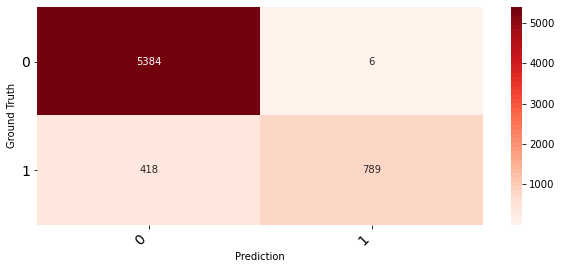

time: 187 ms (started: 2021-06-11 17:08:04 +03:00)


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
fig = plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(train_cats, results)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()


In [30]:
if __name__ == '__main__':
	args = parse_args()

	sess_config = tf.compat.v1.ConfigProto()
	sess_config.gpu_options.allow_growth = True

	with tf.compat.v1.Session(config=sess_config) as sess:
		graph_address = args.model_file + '.meta'
		imported_graph = tf.compat.v1.train.import_meta_graph(graph_address)
		imported_graph.restore(sess, args.model_file)
		mean_param = [v for v in tf.compat.v1.global_variables() if 'mean_tr:0' in v.name][0]
		label_enum_var = [v for v in tf.compat.v1.global_variables() if 'label_enum:0' in v.name][0]
		
		sess.run(tf.compat.v1.variables_initializer([mean_param, label_enum_var]))
		mean_tr = sess.run(mean_param)
		label_enum = sess.run(label_enum_var)

		test_batch, num_cls, _ = read_data(val_data,val_cats, dim=args.dim, label_enum=label_enum)
		test_batch[0], _ = normalize_and_reshape(test_batch[0], dim=args.dim, mean_tr=mean_tr)

		x = tf.compat.v1.get_default_graph().get_tensor_by_name('main_params/input_of_net:0')
		y = tf.compat.v1.get_default_graph().get_tensor_by_name('main_params/labels:0')
		outputs = tf.compat.v1.get_default_graph().get_tensor_by_name('output_of_net:0')

		if args.loss == 'MSELoss':
			loss = tf.reduce_sum(input_tensor=tf.pow(outputs-y, 2))
		else:
			loss = tf.reduce_sum(input_tensor=tf.nn.softmax_cross_entropy_with_logits(logits=outputs, labels=tf.stop_gradient(y)))
		
		network = (x, y, loss, outputs)

		avg_loss, acc, results = predict(sess, network, test_batch, args.bsize)

		# convert results back to the original labels
		inverse_map = dict(zip(np.arange(num_cls), label_enum))
		results = np.expand_dims(results, axis=1)
		results = np.apply_along_axis(lambda x: inverse_map[x[0]], axis=1, arr=results)
    
	print('In test phase, average loss: {:.3f} | accuracy: {:.3f}%'.\
		format(avg_loss, acc*100))

INFO:tensorflow:Restoring parameters from ./saved_model/model.ckpt
Normalize images according to the provided mean.
In test phase, average loss: 0.174 | accuracy: 92.542%
time: 1.98 s (started: 2021-06-11 17:08:06 +03:00)


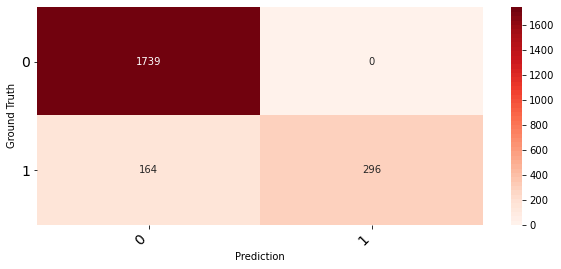

time: 203 ms (started: 2021-06-11 17:08:12 +03:00)


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
fig = plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(val_cats, results)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()